In [1]:
from Preprocessing_Module import read_data, add_topological, add_landcover, merge_new_data, fill_data, select_columns, reshape_dataset, fillna_dataset, remove_nan_features, unused_stations
from Feature_Expansion_Module import feature_expansion
from Initializer_Module import initializer
from XGboost_Model_Module import Xgboost_model
from Neural_Network_Module import FeedforwardNeuralNetModel
from Model_Validation_Module import give_predictions_nn, evaluate_nn, give_predictions_xgboost, evaluate_xgboost, validate_results, merge_predictions
import numpy as np
import pandas as pd

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [3]:
data = read_data('../Datasets/Germany/GER_wuerttemberg_culex_2010_2023.csv')
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_05_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_06_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_07_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_08_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_09_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_env_2024_10_2km_processed.csv', data)
columns = ['dt_placement', 'x', 'y', 'culex.spp', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/germany_wuerttemberg_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/germany_wuerttemberg_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['station_id', 'x', 'y', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex.spp',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_minus_7_avail

In [4]:
# set the date of prediction for the test set
date = '2024-10-01'

# set the filename for export
case = 'Culex_Germany_'

# set the filename to export
path = './predictions/Germany/'
        
title = date[:-3].replace('-','_')
title = case + title

# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'

In [5]:
data = feature_expansion(data)

In [6]:
data = initializer(data, model_type, [-1,   1.,  3.,  8.,  11., 16., 23., 37., 78., 206., np.inf])

Bounds: [ -1.   1.   3.   8.  11.  16.  23.  37.  78. 206.  inf]


In [7]:
print("#===========================================")
print("Performance of the previous month")
print("#===========================================")
print()
validate_results(path+case + date[:-3].replace(date[:-3].split('-')[1],str(int(date[:-3].split('-')[1])-1)).replace('-','_')+'.csv',data)

#===========================================
Performance of the previous month
#===========================================

Mean time difference in days: -3.607142857142857
-------------------
Overall MAE: 1.3571428571428572
Overall % error <=3: 92.86
number of observations: 28
-------------------
MAE with entomological: 2.272727272727273
% error <=3 with entomological: 90.91
number of observations: 11
-------------------
MAE without entomological: 0.7647058823529411
% error <=3 without entomological: 94.12
number of observations: 17
-------------------


#===========================================
Predictions without entomological features
#===========================================

Epoch 001: | Train Loss: 7.08519 | Val Loss: 5.23357 | Train Acc: 1.514| Val Acc: 1.330
Epoch 002: | Train Loss: 5.32831 | Val Loss: 4.00856 | Train Acc: 1.472| Val Acc: 1.301
Epoch 003: | Train Loss: 4.51212 | Val Loss: 3.48745 | Train Acc: 1.384| Val Acc: 1.197
Epoch 004: | Train Loss: 4.32357 | Val Loss: 3.20925 | Train Acc: 1.360| Val Acc: 1.141
Epoch 005: | Train Loss: 3.97435 | Val Loss: 3.02543 | Train Acc: 1.282| Val Acc: 1.093
Epoch 006: | Train Loss: 3.71636 | Val Loss: 2.88863 | Train Acc: 1.239| Val Acc: 1.060
Epoch 007: | Train Loss: 3.60921 | Val Loss: 2.86509 | Train Acc: 1.225| Val Acc: 1.055
Epoch 008: | Train Loss: 3.47126 | Val Loss: 2.72065 | Train Acc: 1.192| Val Acc: 1.033
Epoch 009: | Train Loss: 3.31792 | Val Loss: 2.74621 | Train Acc: 1.164| Val Acc: 1.028
Epoch 010: | Train Loss: 3.23543 | Val Loss: 2.68437 | Train Acc: 1.152| V

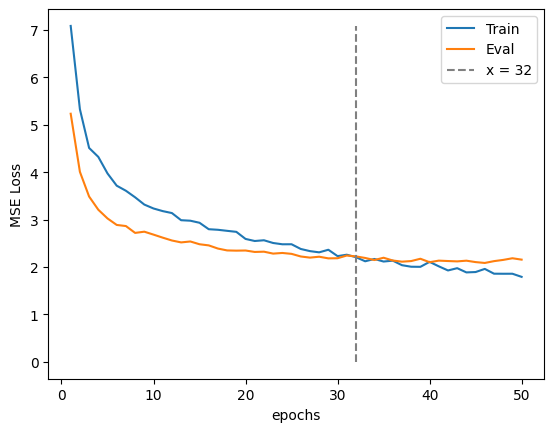

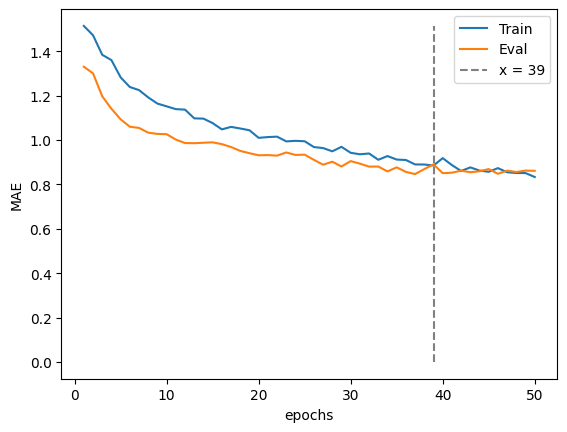

MAE on train set:  0.6149009146341463
min prediction: 0
max prediction: 9

MAE on test set:  0.8819497334348819
Error <= 3: 94.74 %
min prediction: 0
max prediction: 9


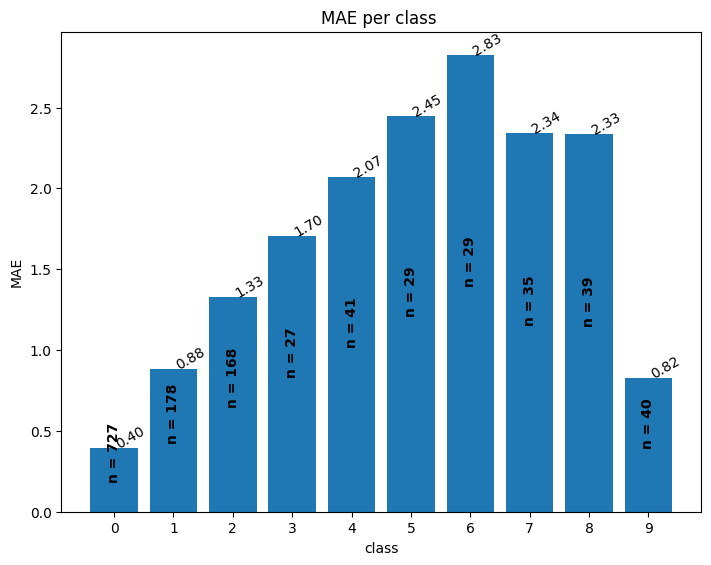

-----------|class error-MAE| difference-----------
mean: 0.9767181849149689
std: 0.6673944697734137
coefficient of variation (std/mean): 0.6833030039586246

----------normalized difference-------------
mean: 0.487728409169765
std: 0.3332662871016616


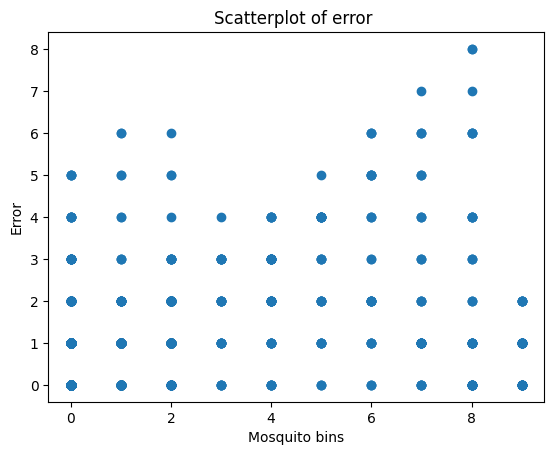

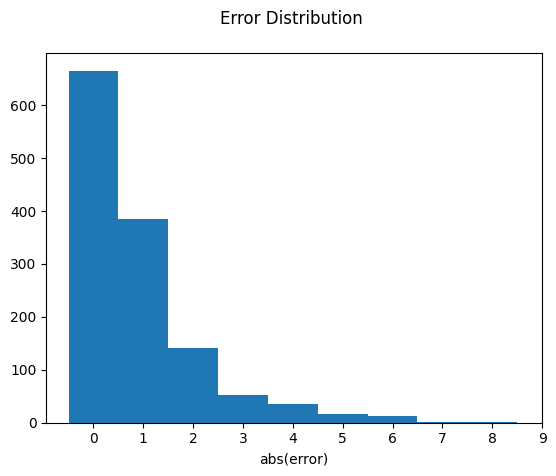

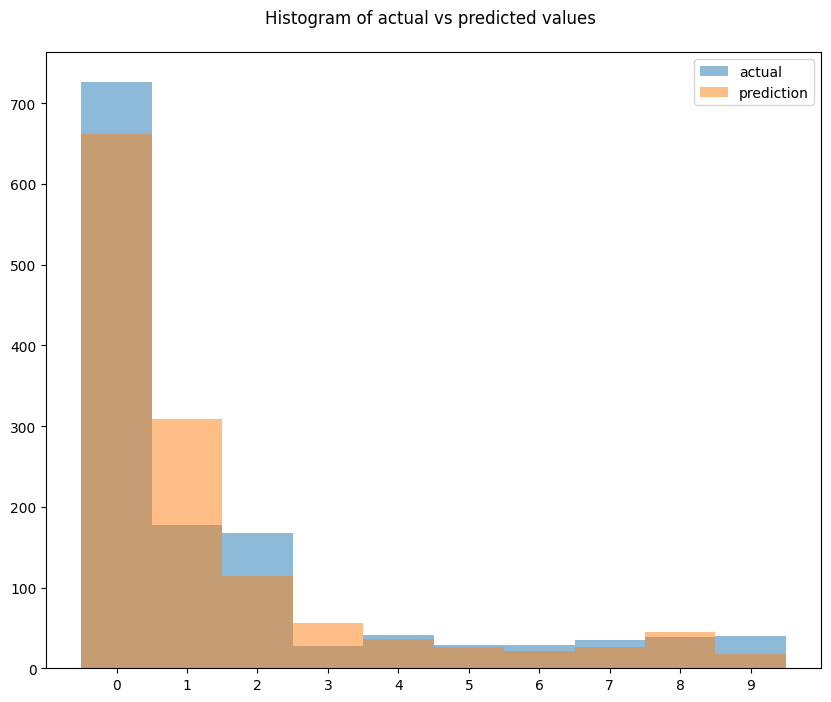

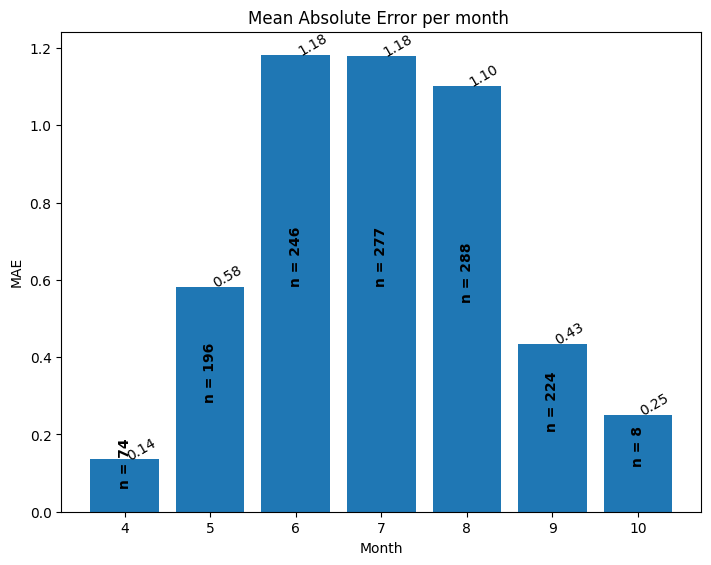

prediction
0    2450
1    1558
2     645
3     438
4     348
5     253
6     140
7      97
8      39
9      15
Name: count, dtype: int64

Low risk category stations: 4008
Medium risk category stations: 1684
High risk category stations: 291
#===========================================
Predictions with entomological features
#===========================================

Epoch 001: | Train Loss: 8.20464 | Val Loss: 9.20271 | Train Acc: 1.574| Val Acc: 1.722
Epoch 002: | Train Loss: 6.23718 | Val Loss: 6.18607 | Train Acc: 1.419| Val Acc: 1.468
Epoch 003: | Train Loss: 4.77620 | Val Loss: 4.73593 | Train Acc: 1.339| Val Acc: 1.330
Epoch 004: | Train Loss: 4.00704 | Val Loss: 3.79626 | Train Acc: 1.264| Val Acc: 1.215
Epoch 005: | Train Loss: 3.61868 | Val Loss: 3.53927 | Train Acc: 1.186| Val Acc: 1.149
Epoch 006: | Train Loss: 3.46816 | Val Loss: 3.14939 | Train Acc: 1.195| Val Acc: 1.137
Epoch 007: | Train Loss: 3.25861 | Val Loss: 2.99446 | Train Acc: 1.158| Val Acc: 1.077
Epoch 008: | 

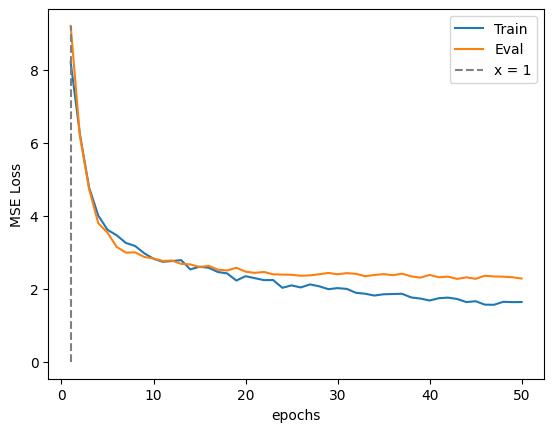

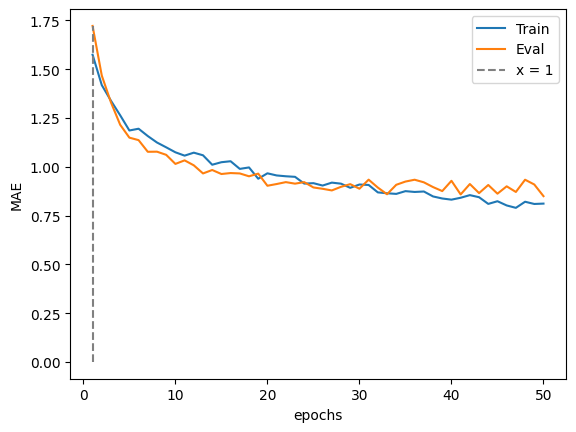

MAE on train set:  0.634647418101055
min prediction: 0
max prediction: 9

MAE on test set:  0.9655937846836848
Error <= 3: 95.01 %
min prediction: 0
max prediction: 9


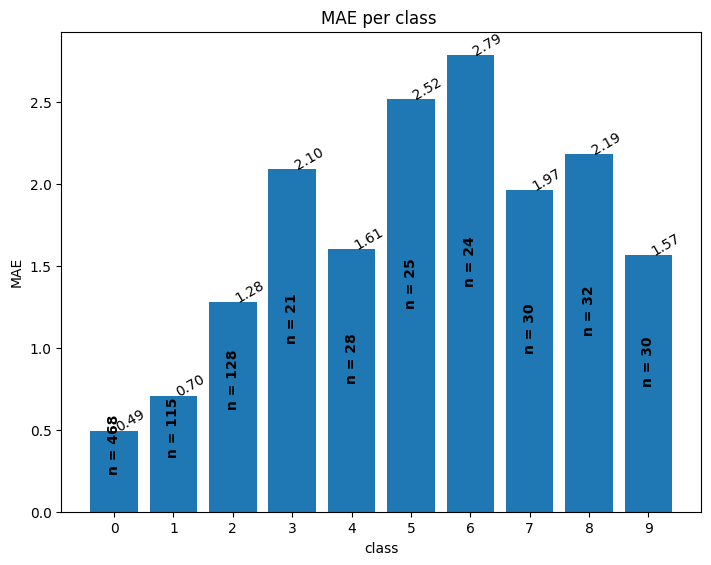

-----------|class error-MAE| difference-----------
mean: 0.5991163468174338
std: 0.4034434883446995
coefficient of variation (std/mean): 0.6733975637417204

----------normalized difference-------------
mean: 0.4890745688305582
std: 0.32934162313853027


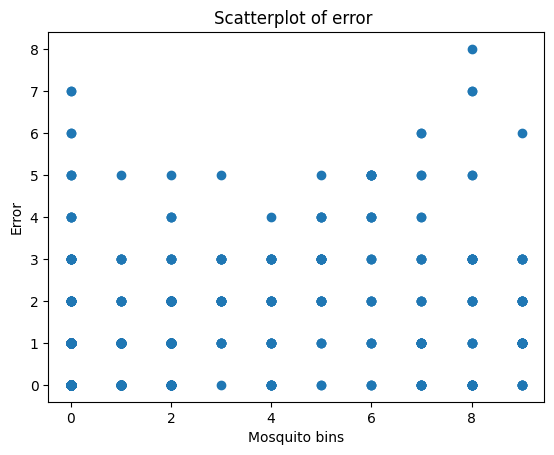

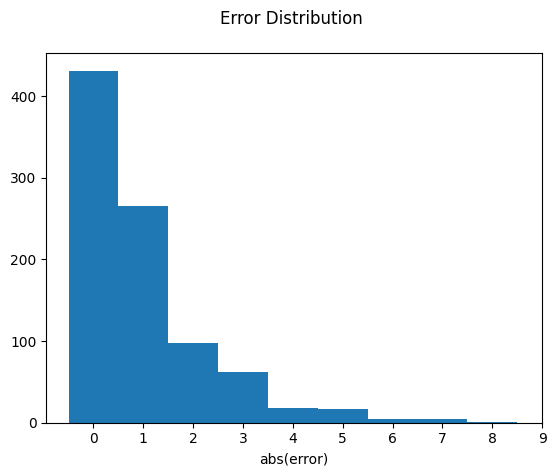

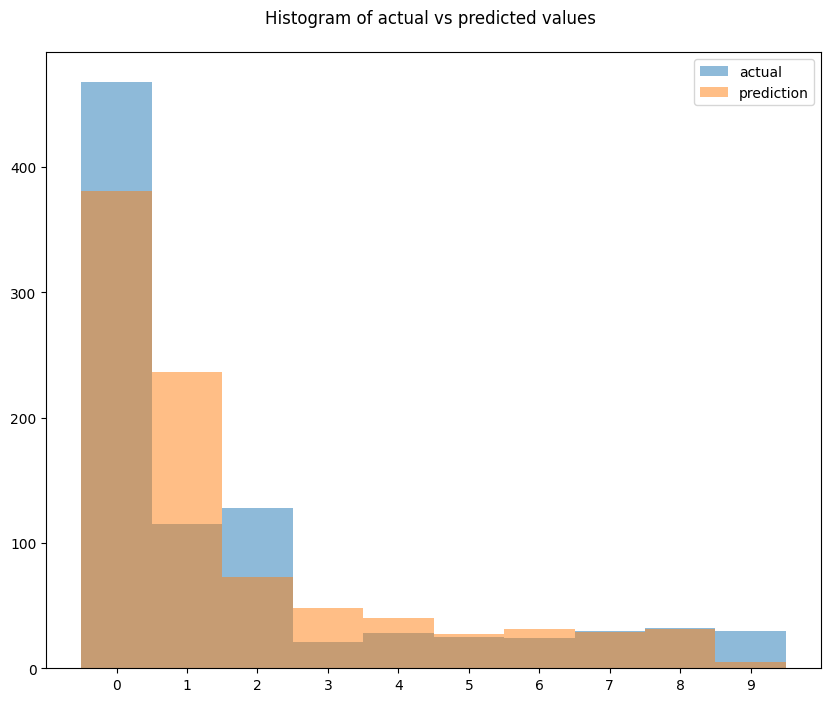

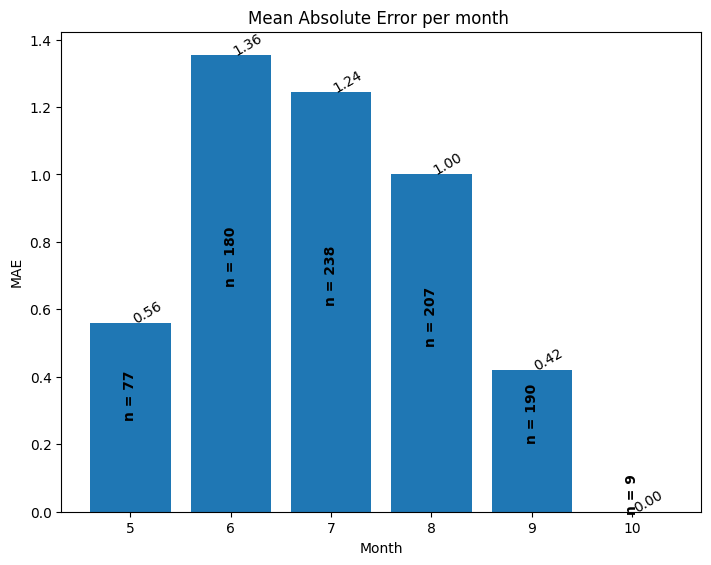

prediction
0    1
1    1
5    1
Name: count, dtype: int64

Low risk category stations: 2
Medium risk category stations: 1
High risk category stations: 0
#===========================================
Predictions with/without entomological features
#===========================================
prediction
0    2451
1    1557
2     645
3     438
4     347
5     254
6     140
7      97
8      39
9      15
Name: count, dtype: int64

Low risk category stations: 4008
Medium risk category stations: 1684
High risk category stations: 291


In [8]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.3)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')
    
num_class = 1
hidden_layers = [264,128,128,64,32]
learning_rate = 0.001
epochs = 50
batch_size = 128
dropout = 0.2
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = ['scaling']
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    del data_env['null_island_distance']
#     del data_env['x']
#     del data_env['y']
    del data_env['vert_distance']
    
    del test_env['null_island_distance']
#     del test_env['x']
#     del test_env['y']
    del test_env['vert_distance']

    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    
    model = FeedforwardNeuralNetModel(num_features=len(data_env.iloc[0,:])-2, num_class=num_class,
                                      hidden_layers = hidden_layers, model_type=model_type,
                                      learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                      dropout = dropout, embedding_data=embedded_data, 
                                      transformation_list=transformation_list, early_stop = early_stop, 
                                      l1_weight=0, l2_weight=0, weights=False)

    evaluate_nn(model, data_env, fi = fi)

    predictions_env = give_predictions_nn(model, data_env, test_env, env = True, filepath = path, case = title,
                                          export = only_env)

    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = FeedforwardNeuralNetModel(num_features=len(data_entom.iloc[0,:])-2, num_class=num_class,
                                          hidden_layers = hidden_layers, model_type=model_type,
                                          learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                          dropout = dropout, embedding_data=embedded_data, 
                                          transformation_list=transformation_list, early_stop = early_stop, 
                                          l1_weight=0, l2_weight=0, weights=False)
        
        evaluate_nn(model, data_entom, fi = fi)

        predictions_entom = give_predictions_nn(model, data_entom, test_entom, env = False, filepath = path,
                                                case = title, export = False)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom,path,title,export=True)

#===========================================
Predictions without entomological features
#===========================================



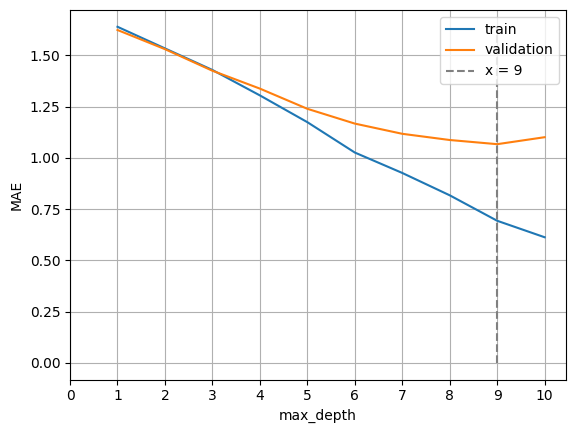

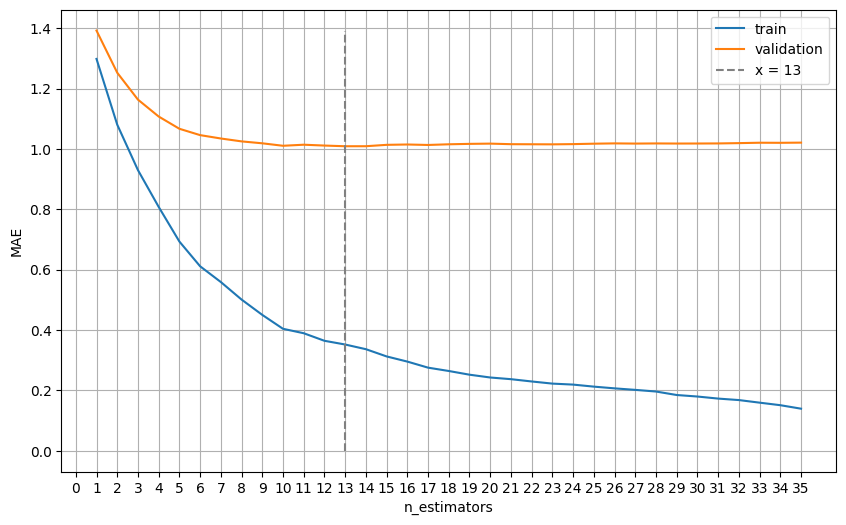

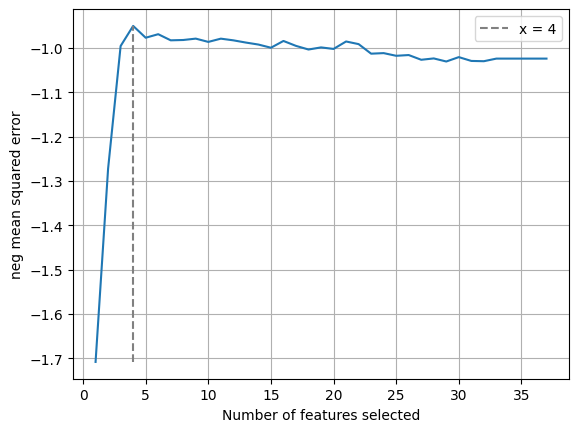

max_depth:  9
Number of estimators:  13
Selected_features:  Index(['ELEVATION_mean_1km', 'days_distance', 'mo_cos', 'year'], dtype='object')
MAE on train set:  0.5004659832246039
min prediction: -0.0
max prediction: 9.0

MAE on test set:  0.8524590163934426
Error <= 3: 96.50 %
min prediction: 0.0
max prediction: 9.0


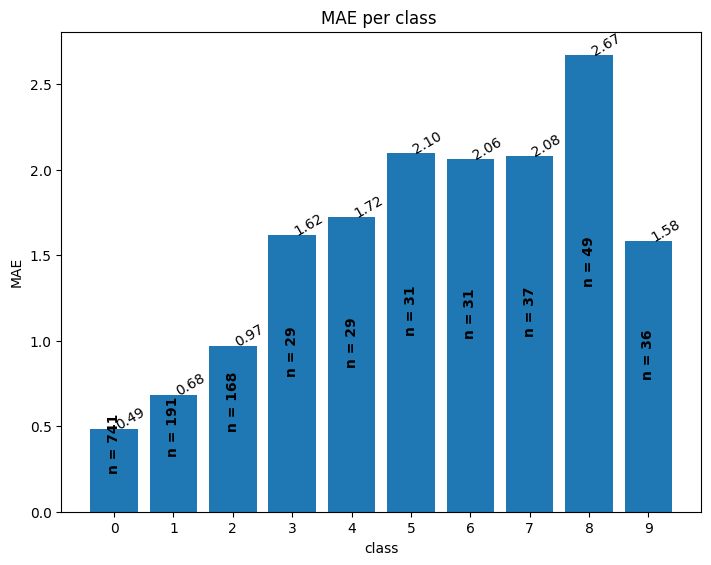

-----------|class error-MAE| difference-----------
mean: 0.537397205062015
std: 0.382079515363792
coefficient of variation (std/mean): 0.7109815826446295

----------normalized difference-------------
mean: 0.48965426246658855
std: 0.34813516247718396


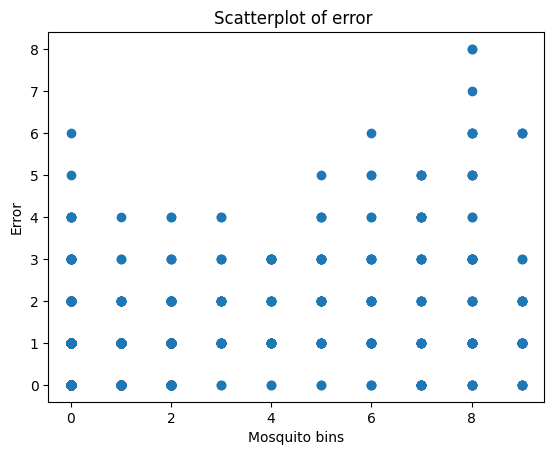

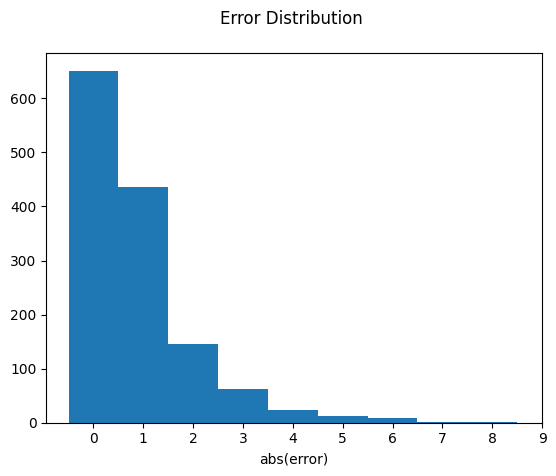

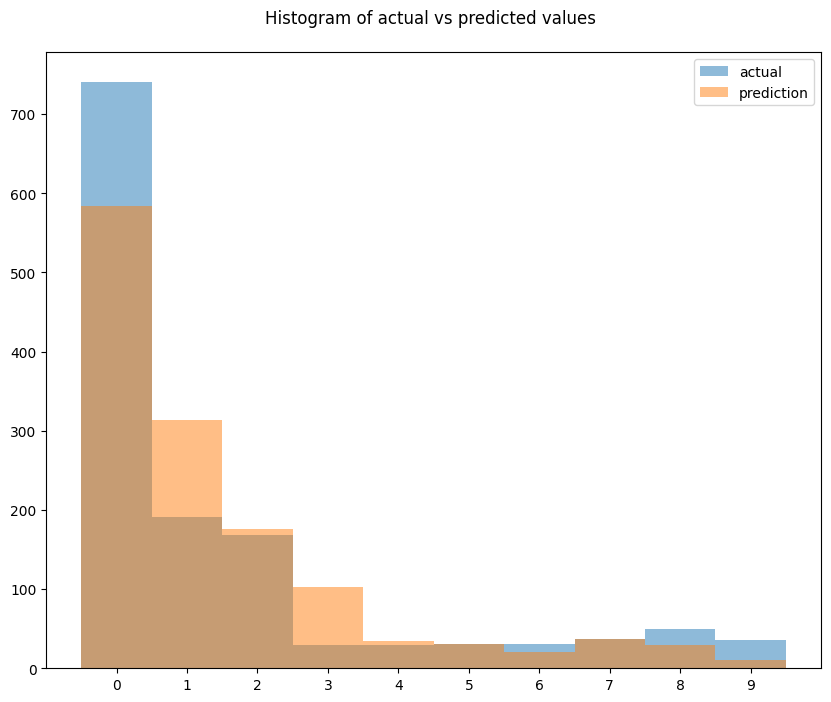

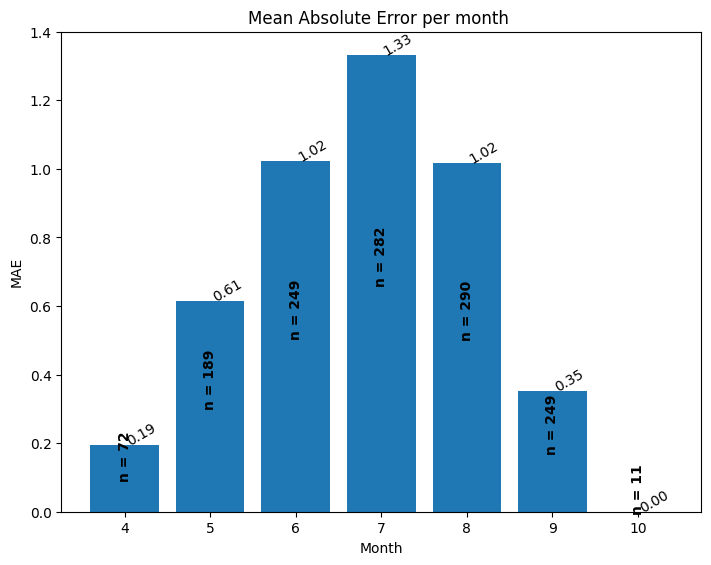

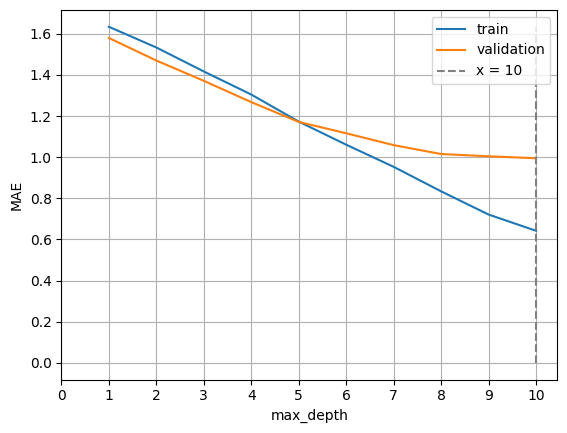

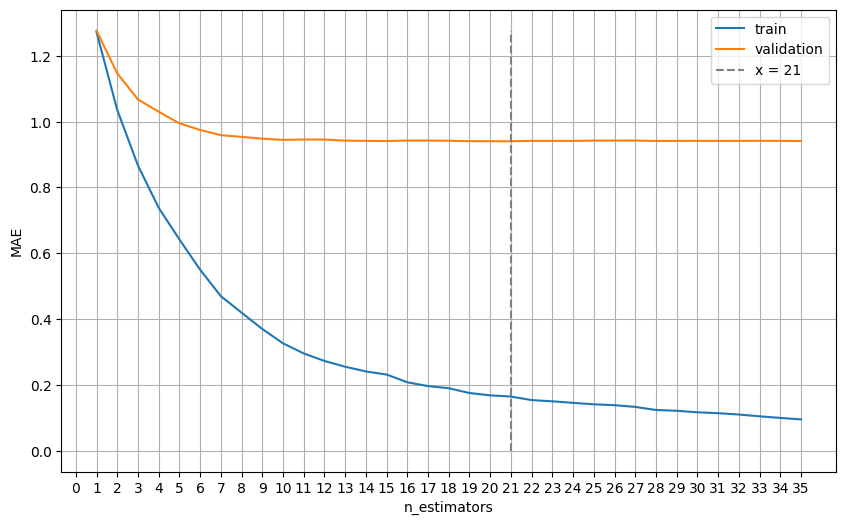

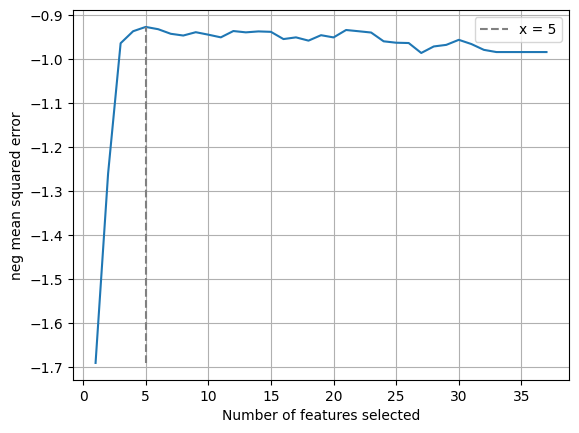

max_depth:  10
Number of estimators:  21
Selected_features:  Index(['ELEVATION_mean_1km', 'HILLSHADE_mean_1km', 'days_distance', 'mo_cos',
       'year'],
      dtype='object')
prediction
0.0    1892
1.0    6025
2.0      91
Name: count, dtype: int64

Low risk category stations: 7917
Medium risk category stations: 91
High risk category stations: 0


In [8]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

data = data.drop(columns = ['acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan'])

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.3)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')
    

learning_rate = 0.3
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    del data_env['null_island_distance']
    del data_env['x']
    del data_env['y']
    del data_env['vert_distance']
    
    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                          embedding_data = embedded_data,  transformation_list = transformation_list,
                          early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
    evaluate_xgboost(model, data_env, fi = fi)

    predictions_env = give_predictions_xgboost(model, data_env, test_env, env = True, filepath = path, case = title,
                                               fi = fi, export = only_env)


    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                              embedding_data = embedded_data,  transformation_list = transformation_list,
                              early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
        evaluate_xgboost(model, data_entom, fi = fi)

        predictions_entom = give_predictions_xgboost(model, data_entom, test_entom, env = False, filepath = path,
                                                     fi = fi, case = title, export = only_env)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom, path, title, export=True)